# ***Voorspellen van Verhuuraantallen*** 

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Declan van den Hoek|declanvdh|DeclanvandenHoek|
|Isa Dijkstra|isadijkstra|IsaD01|

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om de verhuuraantallen te voorspellen. Er is niet bekend gemaakt wat het product is dat wordt verhuurd. Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning/tree/main/Verhuuraantallen), om makkelijk de bestanden te delen. Van elk model zijn de voorspellingen ook geupload naar [Kaggle](https://www.kaggle.com/competitions/voorspel-verhuuraantallen-2023).

## **Inhoudsopgave** <a name='begin'></a>

1. [H1: Inladen libaries en data](#h1)
2. [H2: Explorative Data Analysis](#h2)
    1. [H2.1: Data opschonen](#h2.1)
    2. [H2.2: Grafieken zonder time series](#h2.2)
    3. [H2.3: Time Series Analyses](#h2.3)
        1. [H2.3.1: Seizoens Analyse met FFT](#h2.3.1)
    4. [H2.4: Grafieken met time series](#h2.4)
4. [H3: Modelleren](#h3)
    1. [H3.1: Linear Regression](#h3.1)
    2. [H3.2: KNN Regressor](#h3.2)
    3. [H3.3: Decision Tree Regressor](#h3.3)
    4. [H3.4: Random Forest Regressor](#h3.4)
    5. [H3.5: XGBoost Regressor](#h3.5)
    6. [H3.6: Ensemble, StackingRegressor](#h3.6)
    7. [H3.7: Hybride Modeleren](#h3.7)
    8. [H3.8: SARIMAX Model](#h3.8)
    9. [H3.9: KEUZE_MODEL_ISA](#h3.9)
5. [H4: Bevindingen](#h4)
6. [H5: Conclusie](#h5)
7. [Literatuurlijst](#bronnen)

## **H1: Inladen libaries en data** <a name='h1'></a>

In [3]:
# Standaard libaries voor visualiseren en dataverwerking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libaries gebruikt bij de seizoens analyse
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks

# Libaries gebruikt bij functies rondom modelleren
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Libaries van de modellen
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor

Aan de hand van de pandas libary is het nu mogelijk om de csv bestanden in te laden.

In [4]:
# Inladen van de test dataset
data_test = pd.read_csv('test.csv', sep = ',')

# Inladen van de train dataset
data_train = pd.read_csv('train.csv', sep = ',')

Nu de data is ingeladen zullen de eerste 5 regels worden getoond van de train dataset.

In [5]:
# Tonen van de eerste 5 regels
data_train.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


## **H2: Explorative Data Analysis**<a name='h2'></a>

In dit hoofdstuk zal er worden gewerkt aan de Explorative Data Analysis. Deze stap zal ons helpen om beter inzichten krijgen met betrekking tot de data.

### **H2.1: Data Opschonen** <a name='h2.1'></a>

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen. Vervolgens kan de .describe() method worden gebruikt om een inzicht te krijgen van hoe de numerieke waarden zijn verdeeld.

In [6]:
# Tonen van de kern informatie over kolommen
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [7]:
# Tonen van informatie over numerieke kolommen
data_train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### **H2.2: Grafieken zonder Time Series** <a name='h2.2'></a>

### **H2.3: Time Series analyses** <a name='h2.3'></a>

Omdat er met Time-Series data wordt gewerkt, is het nodig om deze verder te gaan onderzoeken. Hiervoor is eerst een nieuw dataframe nodig, waarin alleen de tijd en de verhuuraantallen staan.

In [8]:
# Aanmaken van nieuw DataFrame
df_time = data_train[['date_hour', 'cnt']]
df_time = df_time.set_index('date_hour')
df_time.head()

,cnt
date_hour,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


#### **H2.3.1: Seizoens Analyse (met FFT)** <a name='h2.3.1'></a>

Nu het dataframe df_time is aangemaakt kan deze gebruikt worden voor verschillende time-series analyse technieken. Deze technieken worden gebruikt om patronen uit de tijds data te kunnen halen. Om hiermee te beginnen wordt het dataframe in een grafiek gezet. Hierbij zal 2012 gehighlight worden om snel te kunnen zien waar in de grafiek de strat van het nieuwe jaar zich bevindt.

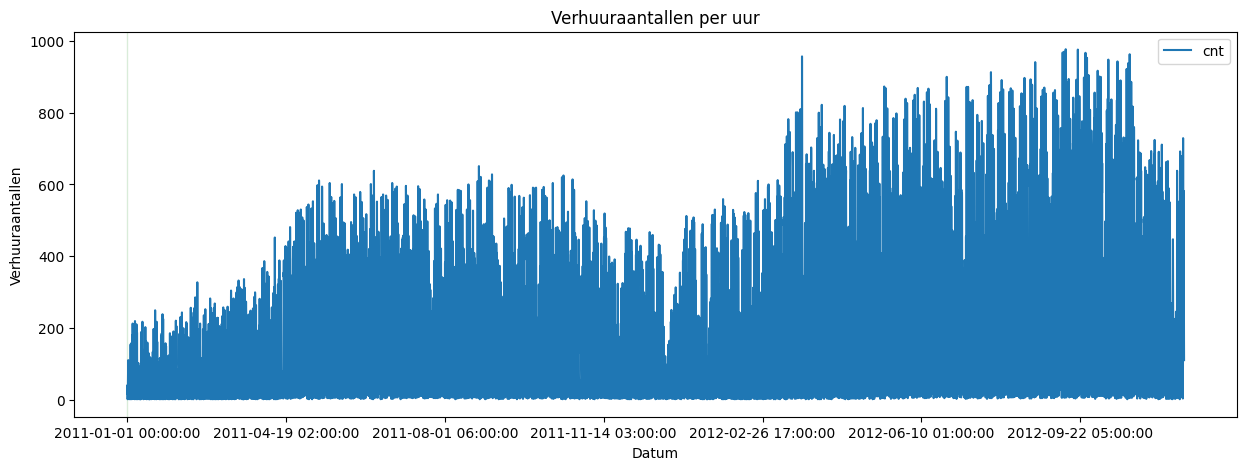

In [9]:
# Aanmaken van standaard plot
ax = df_time.plot(figsize=(15, 5))

# Toevoegen van shading om beter te zien waar 2012 begint
ax.axvspan('2012-01-01', '2013-01-01', color='green', alpha=0.15)

# Aanpassen van de plot labels en titel
ax.set_xlabel("Datum")
ax.set_ylabel("Verhuuraantallen")
ax.set_title("Verhuuraantallen per uur")

# Tonen van de plot
plt.show()

Door de frequentie van de data (elk uur) is er een te grote schommeling tussen de mogelijke waarden. Om beter te kunnen kijken naar eventuele patronen is het dus nodig om in te gaan zoomen op bepaalde perioden. Om te beginnen met inzoomen kijken we naar de maand april.

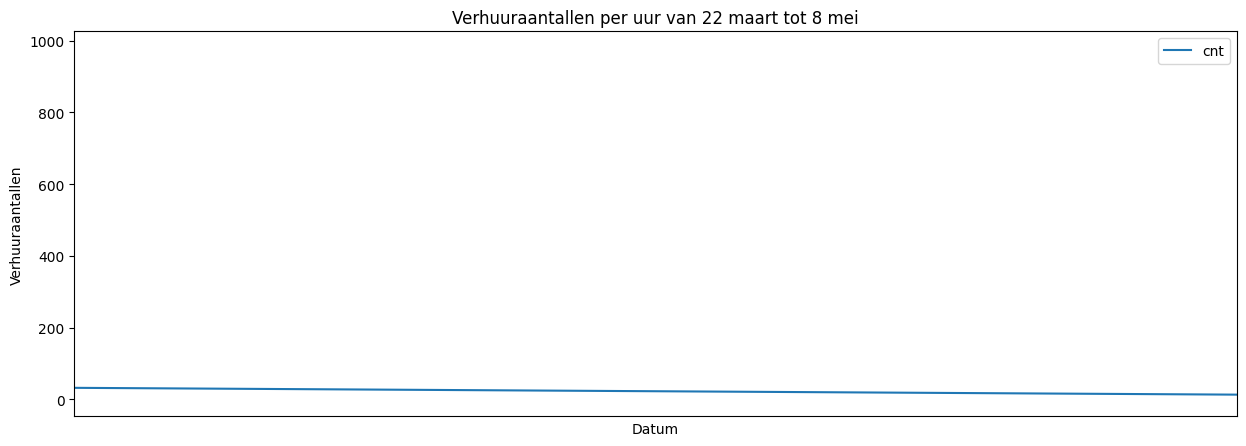

In [10]:
# Aanmaken van standaard plot
ax = df_time.plot(figsize=(15, 5))

# Toevoegen van shading om beter te zien welke data April is
ax.axvspan('2012-04-01', '2012-05-01', color='green', alpha=0.15)

# Aanpassen van de plot labels en titel
ax.set_xlim('2012-03-22', '2012-05-08')
ax.set_xlabel("Datum")
ax.set_ylabel("Verhuuraantallen")
ax.set_title("Verhuuraantallen per uur van 22 maart tot 8 mei")

# Tonen van de plot
plt.show()

Wat hier te zien valt is dat er een patroon vormt in de pieken. Dit patroon herhaalt zich relatief consistent. Hoewel deze rond 22 april zich niet herhaald, is het belangrijk om niet van de uitzondering de regel te gaan maken. Omdat deze herhaling per maand meerdere malen voorkomt is het van belang om te kijken naar de data per week. Op deze manier kan vastgesteld worden of er per week ook een herlaing plaats vind. Om dit gemakkelijk te berekenen en te visualiseren wordt er gebruik gemaakt van de seasonal_decompose functie van de statsmodels libary.

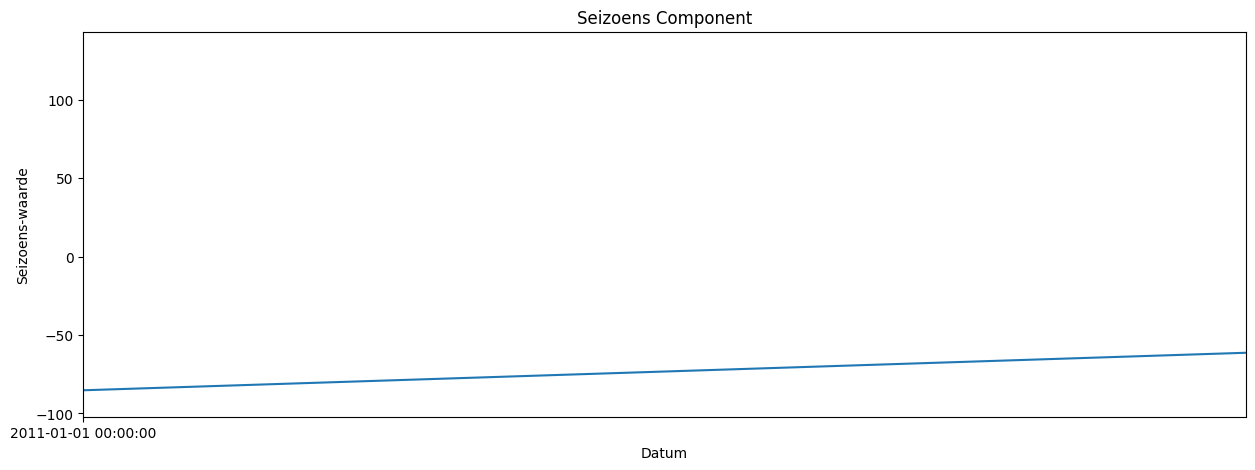

In [11]:
# Gebruiken van seasonal_decompose om seizoens patronen te visualiseren
result = seasonal_decompose(df_time['cnt'], model='additive', period=24*7)

# Maken van de plot
plt.figure(figsize=(15, 5))
result.seasonal.plot()
plt.title('Seizoens Component')
plt.xlim('2012-04-01', '2012-05-01')
plt.xlabel('Datum')
plt.ylabel('Seizoens-waarde')
plt.show()

Wat hier te zien valt is dat er een duidelijke seizoensmatige beweging in de data zit. Momenteel is er een patroon dat zich 4 maal volledig toont. Vanuit deze wetenschap is er dan vanuit te gaan dat deze seizoenspatronen ongeveer een week duren. Om dit beter te kunnen bekijken zoomen we nu in op een periode van 10 dagen. Hierin zou het patroon zich moeten uiten en zal er een nieuwe herhaling aan het einde moeten beginnen.

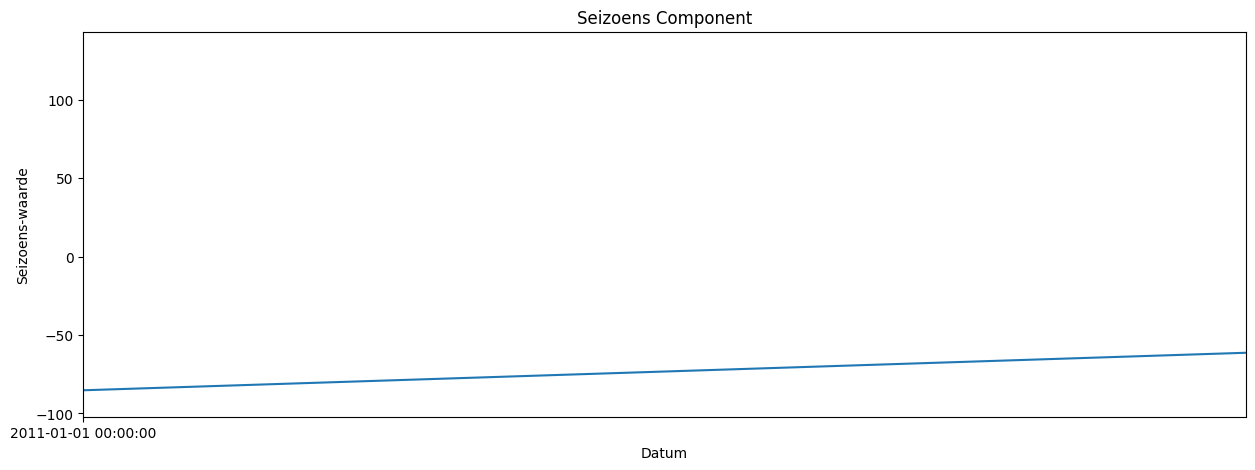

In [12]:
# Gebruiken van seasonal_decompose om seizoens patronen te visualiseren
result = seasonal_decompose(df_time['cnt'], model='additive', period=24*7)

# Maken van de plot
plt.figure(figsize=(15, 5))
result.seasonal.plot()
plt.title('Seizoens Component')
plt.xlim('2012-04-01', '2012-04-10')
plt.xlabel('Datum')
plt.ylabel('Seizoens-waarde')
plt.show()

Dagelijks herhaalt zich een soortgelijk patroon. Er zijn kleine verschillen in aan te wijzen, maar de meeste dagen bevatten 2 pieken. Deze pieken vormen zich langzamerhand samen, waarna het weer scheidt naar twee pieken. De periode die het duurt om same te voegen is 5 dagen, terwijl de periode om te splitsen 2 dagen duurt. Het is aannemelijk dat het hierbij dus om de werkdagen en het weekend zal gaan.

Peaks found at [692 694]


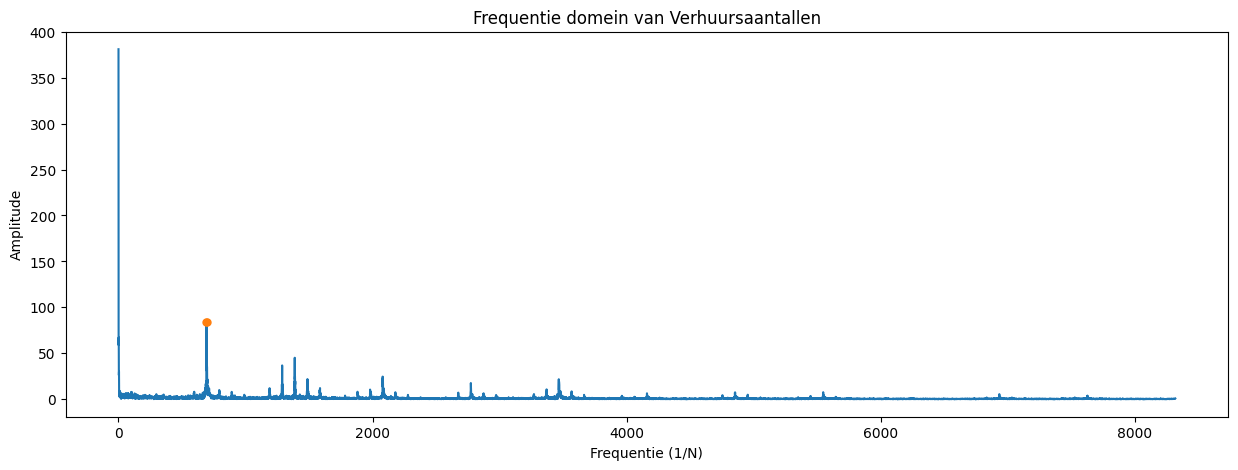

In [13]:
# Berekenen aantal datapunten
N = len(df_time)

# Uitvoeren Fourier Transform
ft = np.fft.fft(df_time['cnt'])

# Bereken de kracht van de frequenties
magnitude = 2.0/N * np.abs(ft[:N//2])

# Zoeken en tonen van de pieken
peaks, _ = find_peaks(magnitude, height=75)
print(f"Peaks found at {peaks}")

# Plotten
plt.figure(figsize=(15,5))
plt.plot(magnitude)
plt.xlabel('Frequentie (1/N)')
plt.ylabel('Amplitude')
plt.title('Frequentie domein van Verhuursaantallen')
plt.plot(peaks, magnitude[peaks], ".", markersize=10)

plt.show()

Nu de locatie van de hoogste piek is gevonden, kunnen de frequentie en de periode worden berekend. Doordat peaks een lijst is met 2 waarden, kan er voor beide waarden de periode worden berekend.

In [14]:
freq = peaks * (1 / N)
periode = 1 / freq
print(f'De periode van FFT is: {np.round(periode, 0)}')

De periode van FFT is: [24. 24.]


Een periode geeft aan dat de Fourier Transform een periodieke herhaling ziet om de 24 tijdsperioden. In onze dataset betekent dit dat er elke dag een patroon plaats vind. Hoewel we al weten dat dit patroon kan verschillen op basis van weekend of geen weekend, was er ook te zien dat van maandag tot en met vrijdag de bewegingen van de grafiek gelijk aan elkaar waren. Om deze reden zullen de kolommen 'day_of_week' en 'is_weekend' worden togevoegd, zodat de patronen gebruikt kunnen worden voor Machine Learning.


### **H2.4: Grafieken met Time Series** <a name='h2.4'></a>

Eerst zullen er de benodigde functies worden aangemaakt, om op die manier gemakkelijk de verschillende nieuwe time-series kolommen aan te maken. In de loop van het project zullen er kolommen worden toegevoegd aan deze functie. Hier is een korte omschrijving over de later toegevoegde kolommen en waarom ze zijn toegevoegd:

- De 'is_weekend' kolom is toegevoegd nadat er in de seizoens analyse is opgevallen dat er een verschil was in de pieken op twee dagen. Hiermee is afgeleid dat deze dagen in het weekend zullen zitten. Later is dit bevestigd door middel van een grafiek.
- De 'day_of_week' kolom is toegevoegd nadat de fourier transform een patroon van 24 tijdseenheden aan heeft gegeven. Elke 24 tijdseenheden staat in het dataframe gelijk aan een dag, waardoor de dag van de week is toegevoegd.

In [15]:
def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Toegevoegd op basis van eigen ingeving
    df['Jaar'] = df[f'{dt_kol}'].dt.year.astype(int)
    df['Maand'] = df[f'{dt_kol}'].dt.month.astype(int)
    df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week.astype(int)
    df['Uur'] = df[f'{dt_kol}'].dt.hour.astype(int)

    # Toegevoegd na aanleiding FFT
    df['is_weekend'] = (df[f'{dt_kol}'].dt.dayofweek >= 5).astype(int)
    df['day_of_week'] = df[f'{dt_kol}'].dt.weekday.astype(int)

    return df

Deze functies zullen helpen om nieuwe kolommen toe te voegen aan data_train, en later ook aan data_test.

In [16]:
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Week,Uur,is_weekend,day_of_week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,52,0,1,5
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,52,1,1,5
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,52,2,1,5
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,52,3,1,5
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,52,4,1,5


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_hour    16637 non-null  datetime64[ns]
 1   holiday      16637 non-null  int64         
 2   weathersit   16637 non-null  int64         
 3   temp         16637 non-null  float64       
 4   atemp        16637 non-null  float64       
 5   hum          16637 non-null  float64       
 6   windspeed    16637 non-null  float64       
 7   cnt          16637 non-null  int64         
 8   Jaar         16637 non-null  int32         
 9   Maand        16637 non-null  int32         
 10  Week         16637 non-null  int32         
 11  Uur          16637 non-null  int32         
 12  is_weekend   16637 non-null  int32         
 13  day_of_week  16637 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(6), int64(3)
memory usage: 1.4 MB


In [18]:
class Grafieken:
    """
    Een class voor eenvoudig visualiseren met Matplotlib
    en seaborn.

    Parameters:
    ----------
    df : pandas.DataFrame
        Een pandas.DataFrame die data bevat om mee te
        visualiseren.
    """

    def __init__(self, df):
        """
        De constructor voor de Grafieken class

        Parameters:
        ----------
        df : pandas.DataFrame
            Een pandas.DataFrame die data bevat om mee te
            visualiseren.
        """
        # Aanmaken self.df
        self.df = df

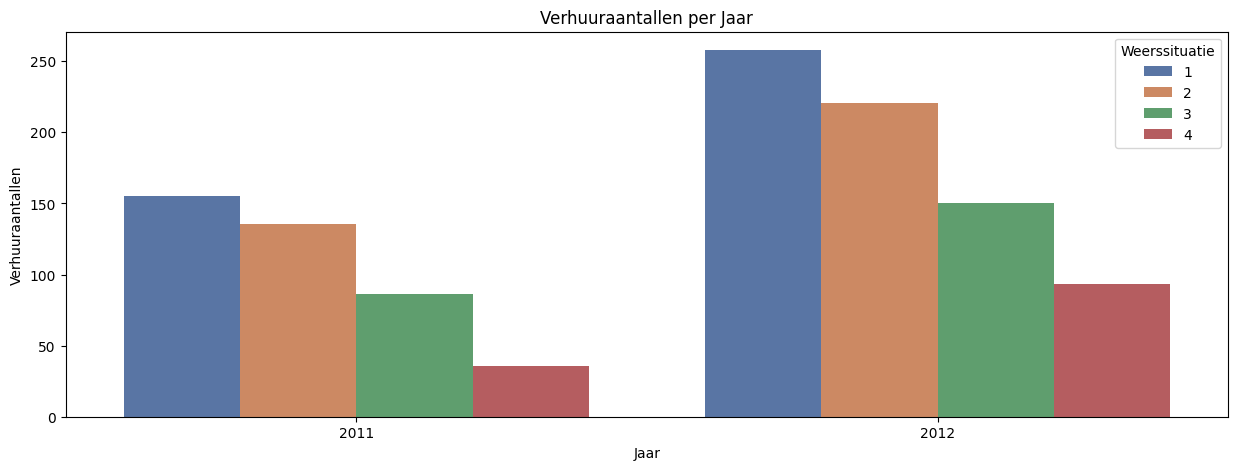

In [19]:
plt.subplots(figsize=(15, 5))
sns.barplot(data=df, x='Jaar', y='cnt',
            hue='weathersit', errorbar=None,
            palette='deep')

plt.title('Verhuuraantallen per Jaar')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Weerssituatie')
plt.show()

Zoals hierboven te zien is, zijn er in 2012 meer verhuursaantallen. Ook is er heel duidelijk te zien dat er een duidelijk verschil is tussen de verschillende weersituaties. Dat de weersomstandigheden een grote invloed hebben is mogelijk als het te verhuren product gebruikt wordt zonder afdekking van regen of andere neerslag.

Bij een weerssituatie van klasse van 1 is er een algemeen hoger verhuur, dit neemt af naarmate je omhoog gaat op de schaal. Hieronder is verduidelijking over de schaal van deze kolom:

**weathersit**:
1. Helder, licht bewolkt, deels bewolkt
2. Mistig , mistig en licht bewolkt
3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte
regen en zwaar bewolkt
4. Zware regen, hagel, zware mist, sneeuw.

Voor verder onderzoek wordt er nu gekeken naar de verdeling van het verhuur per uur.

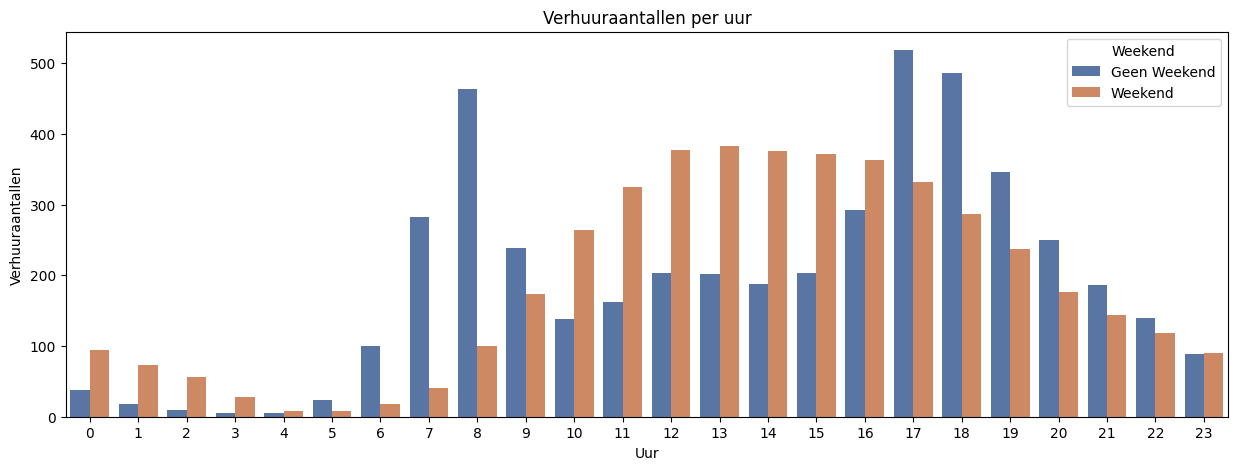

In [20]:
plt.subplots(figsize=(15, 5))
sns.barplot(data=df, x='Uur', y='cnt',
            hue='is_weekend', errorbar=None,
            palette='deep')

plt.title('Verhuuraantallen per uur')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Weekend',
           labels=['Geen Weekend', 'Weekend'])
plt.show()

De grafiek over de verhuuraantallen per uur geeft ook een duidelijke boodschap. Rond de uren van 6 t/m 8 vindt er een sterke stijging plaats, wat niet heel raar is aangezien de meeste mensen tussen 6 en 8 wakker worden. Rond de uren van 17 en 18 is er ook een gigantische piek. Echter is dit alleen van maandag t/m vrijdag, dit zijn de algemene werkdagen. 

In de weekenden zit de hoogste piek rond het begin van de middag. Wat aan dit verschil ook opvalt is dat er in de daluren (behalve van 20 t/m 22) in het weekend altijd meer verhuur is. Terwijl in de spitsuren het juist drukker is op werkdagen.

Om iets meer inzicht te krijgen over het algemene verhuur gedrag zal deze grafiek nagemaakt worden met boxplots, om zo de verdeling en de outliers ook duidelijk te zien.

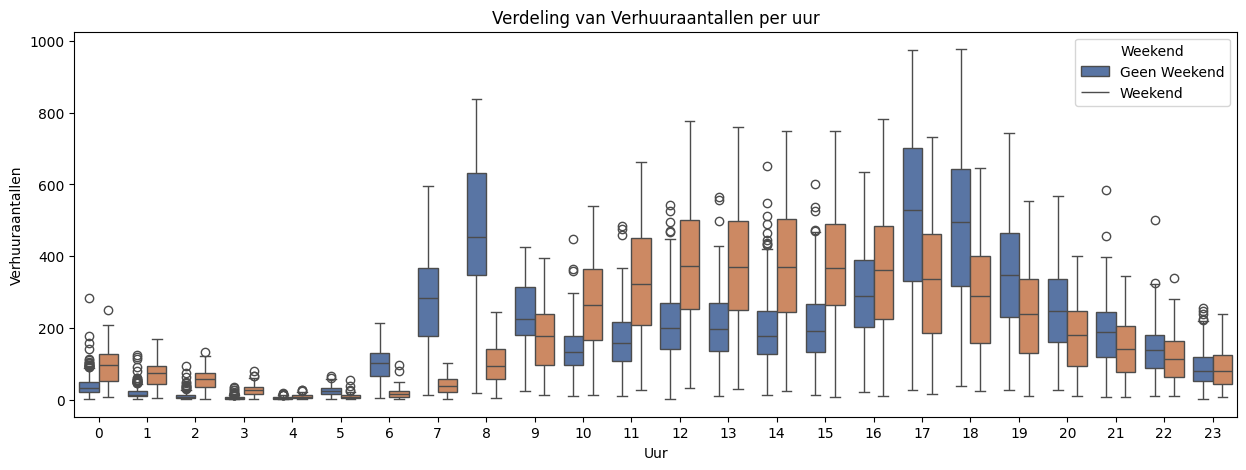

In [21]:
# Aanmaken van plotgrootte en boxplot
plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='Uur', y='cnt',
            hue='is_weekend', palette='deep')

# Titel en tonen van de grafiek
plt.title(f'Verdeling van Verhuuraantallen per uur')
plt.ylabel('Verhuuraantallen')
plt.legend(title='Weekend',
           labels=['Geen Weekend', 'Weekend'])
plt.show()

Het voordeel aan boxplots is dat er per waarde op de x-as een verdeling wordt getoond. Deze verdeling laten zien waar het gemiddelde ligt en of er outliers aanwezig zijn. Wat opvalt is de afwezigheid van outliers in de drukste uren van het verhuren en dat outliers ook enigzins afhankelijk zijn van tijd en de weekdag. Verder is het ook opvallend dat er geen outliers zijn aan de onderkant van de boxplots.

## **H3: Modelleren** <a name='h3'></a>

Tijdens deze stap gaat er gemodelleerd worden. Bij elk model zijn er ook tussenstappen waarbij features worden toegevoegd of verwijderd, om op deze manier de invloed van de features te kunnen beoordelen.

In [22]:
df_test = data_voorbereiding(data_test, 'date_hour')
df_test.drop('date_hour', axis=1, inplace=True)

In [23]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(df_test)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Tonen van de resultaten
    return print(f'Root Mean Squared Error: {rmse}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste RMSE: {abs(gs.best_score_)}")
    print(f"Beste parameters:\n{gs.best_params_}")

def feature_scan(model):
    """
    Een functie die een grafie met de feature importances kan maken.
    Dit werkt in ieder geval voor de RF en XGB modellen.

    Parameters:
    ----------
    model : ML-model
    Het model waarvan je de feature importances wilt tonen.

    Returns:
    ----------
    None
    Laat een grafiek zien met daarin de invloed van alle features.
    """
    # Aanmaken en sorteren invloed kolommen
    invloed = pd.Series(model.feature_importances_, index=X.columns)
    invloed = invloed.sort_values(ascending=True)

    # Plotten grafiek met invloed
    invloed.plot(kind='barh', figsize=(10, 6))
    plt.ylabel('Features')
    plt.xlabel('Invloed')
    plt.show()
    

In [24]:
# Aanmaken SEED voor random_state
SEED = 42

# Aanmaken van X en y
df_train = df.drop(['date_hour'], axis=1)
X = df_train.drop('cnt', axis=1)
y = df_train['cnt']

# Splitten van de data in train en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=456, random_state=SEED)

# Aanmaken van de folds
cv = TimeSeriesSplit(n_splits=5, test_size=456)

### **H3.4: Random Forest Regressor** <a name='h3.4'></a>

Als __ keuze model is er gekozen om Random Forest te gaan gebruiken. Random forest begint met het aanmaken van meerdere decision tree modellen, die elk tegelijk gaan trainen en voorspellen. Deze methode heet ensemble learning, het gebruiken van verschillende of meerdere modellen om tot een voorspelling te komen. Bij een Random Forest wordt er enkel gebruik gemaakt van Decision Trees. Nadat elk van de trees een voorspelling heeft gemaakt, wordt uit die voorspellingen het gemiddelde berekent om zo tot een antwoord te komen op het regressie probleem.

Het aantal gebruikte features is bij een Random Forest afhankelijk van een hyper-parameter: max_features. Deze parameter zorgt ervoor dat er een limiet zit op de features, zodat het ensemble model niet te afhankelijk kan worden van een paar features. Ook niet alle data wordt bij elke tree ingezet, om te zorgen dat er een extra willekeur inzit om overfitting tegen te gaan. (Chakure, 2022)

Deze eigenschappen van Random Forest zijn waarom wij het model gaan gebruiken.

In [25]:
# Opstellen van Random Forest Regressor model
rf = RandomForestRegressor(random_state=SEED,
                              n_jobs=-1)

# Bekijken van de RMSE
model_score(rf)

Root Mean Squared Error: 33.29031536901417


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [26]:
# Opstellen van de parameter dict
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Uitvoeren van de gridsearch
# grid_score(rf, param_rf)

Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [27]:
# Toepassen van optimale parameters
rf_tuned = RandomForestRegressor(n_estimators=50,
                           max_depth=20,
                           min_samples_leaf=1,
                           random_state=SEED,
                           n_jobs=-1)

# Bekijken van de RMSE
model_score(rf_tuned)

Root Mean Squared Error: 33.811787637037796


Nu het getunede model van Random Forest is uitgevoerd, kan er gekeken worden naar de verschillende feature importances. Een grafiek met deze data geeft aan welke kolommen invloed hebben en hoe sterk de invloed is.

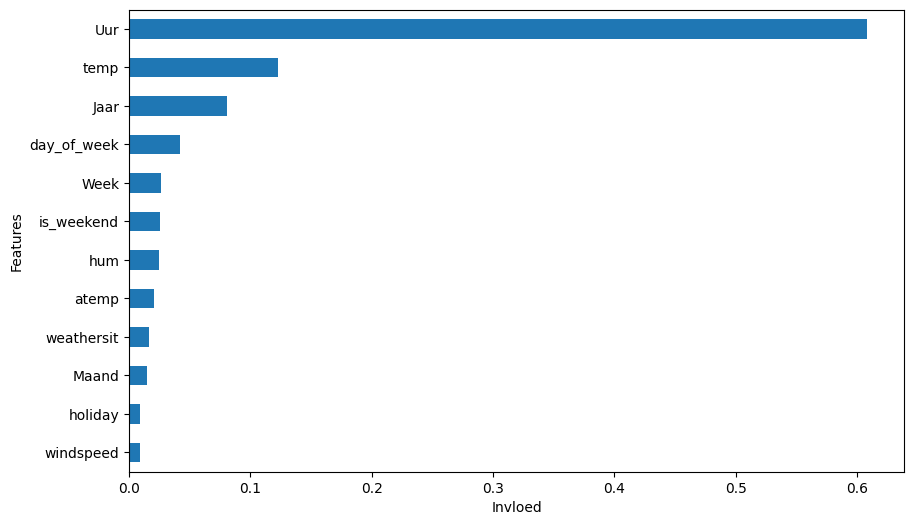

In [28]:
feature_scan(rf_tuned)

In [29]:
#submissie(rf_tuned, 'RF_2fa')

De bovenstaande grafiek toont dat, voor het maken van een random forest voorspelling, de waarden van uur en temperatuur het belangrijkste zijn. De kolom holiday heeft duidelijk het minste invloed op de voorspelling. Verder is uur duidelijk de waarde waarop het model haar voorspellingen het meest heeft gebaseerd. In de EDA was er ook duidelijk te zien dat het uur van de dag grote invloed had op de verhuuraantallen, dus dat het model hier voor heeft gekozen is logisch.

### **H3.5: XGBoost Regressor** <a name='h3.5'></a>

Als __ keuze model is er gekozen om gebruik te maken van XGBoost Regressor. Dit model heeft enkele voordelen die er toe hebben geleid om dit model te kiezen. Volgens Kumar (2019) is een van de voordelen de regularisatie van een XGBoost model. Dit model bevat zowel Lasso (L1) als Ridge (L2) regularisatie, wat ervoor zorgt dat het model moeilijker overfit. Via de Scikit Learn libary is het mogelijk om verschillende waarden, als hyperparameters, toe te voegen aan het model. De parameter alpha is voor L1 regularisatie en de parameter lambda is voor L2 regularisatie.

Een ander voordeel is de manier waarop het model pruning toepast. Bij een XGBoost model worden de bomen pas aan het einde van het model gepruned. Dit zorgt ervoor dat als er een enkele split met een negative loss voorkomt, het model niet de tak daar laat stoppen. Het model zal eerst doorgaan tot de aangegeven max_depth voordat deze gaat prunen. (Kumar, 2019)

Daarnaast is een ander groot voordeel dat XGBoost een parallel lopende ensemble is. Dit betekent dat de bomen tegelijkertijd kunnen worden opgebouwd, in tegen stelling to achtereenvolgend. Dit zorgt voornamelijk in een kortere run time bij het trainen van het model. (Hanchman, 2023)

Als eerste stap trainen we een model met enkel de standaard parameters.

In [30]:
# Opstellen van XGBoost Regressor model
xgb = XGBRegressor(n_jobs=-1,
                   random_state=SEED)

# Bekijken van de RMSE
model_score(xgb)

Root Mean Squared Error: 34.03833317668675


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [31]:
# Opstellen van de parameter dict
param_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [5, 10, 20],
}

# Uitvoeren van de gridsearch
# grid_score(xgb, param_xgb)

Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [32]:
# Toepassen van optimale parameters
xgb_tuned = XGBRegressor(n_estimators=300,
                         learning_rate=0.1,
                         max_depth=10,
                         random_state=SEED,
                         n_jobs=-1)

# Bekijken van de RMSE
model_score(xgb_tuned)

Root Mean Squared Error: 29.55060309460792


Ook bij XGBoosting zal worden gekeken naar de feature importance.

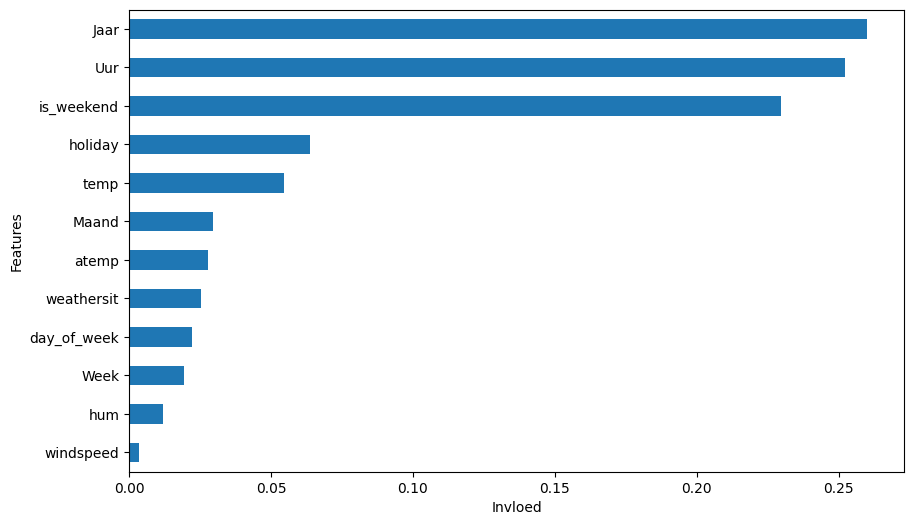

In [33]:
feature_scan(xgb_tuned)

De bovenstaande grafiek toont dat, voor het maken van een XGBoost voorspelling, de waarden van uur en jaar het belangrijkste zijn. De kolom windspeed heeft het minste invloed op de voorspelling. De waarden van uur en jaar liggen dichtbij elkaar qua invloed. Wat bij deze grafiek ook duidelijk is te zien, is dat alle waarden iets hoger liggen dan bij random forest.

In [34]:
#submissie(xgb_tuned, 'XGB_2fa')

### **H3.6: Ensemble, StackingRegressor** <a name='h3.6'></a>

Binnen machine learning zijn er vele verschillende ensemble modellen, dit zijn modellen die gebruik maken van andere modellen om zo de voorspellingte kunnen vormen. Binnen het kader van Ensemble learning zijn er drie verschillende typen: bagging, boosting en stacking. 

**Bagging:**<br>
Bij bagging wordt de data gesplitst in meerdere gelijke delen, een voorbeeld hiervan komt voor bij RandomForestRegressor. Elke tree die RandomForest aanmaakt gebruikt een andere subset aan features om de voorspelling te maken. Van deze voorspelling wordt vervolgens een gemiddelde berekent, deze waarde dient als de voorspelling van het model.

**Boosting:**<br>
Bij boosting wordt er eerste een model getrained op de dataset. Vervolgens gaat het tweede model zich bezig houden met het verbeteren van de voorspelling, dit gebeurt door de gewichten op de verkeerd voorspelde datapunten te vergroten. Dit herhaalt zich totdat er geen verbetering meer plaats vind of tot het maximale aantal rondes is bereikt. Een populair voorbeeld van boosting in ML is het gebruik van ADABoost.

**Stacking:**<br>
Als keuze voor een ensemble model is er gekozen om te werken met StackingRegressor. Net als bij bagging en boosting combineerd stacking meerdere modellen om tot een voorspelling te komen voor de dataset. Anders dan bij bagging zijn er verschillende modellen die op dezelfde data worden getrained. En anders dan bij boosting word een ander model gebruikt om deze voorspellingen om te zetten naar een enkele waarde (Brownlee, 2021). Dit zorgt ervoor dat een stacking model de voor en nadelen van meerdere modellen kan combineren om een, hopelijk, sterker model te bouwen.

Wiskundig gezien kan je elke collectie van voorspelling als volgt classificeren: $\hat{y}_i,_s$. Dit staat voor de voorspelling $\hat{y}$ gebaseerd op de basis modellen $i$ op basis van sample $s$. Deze waarden worden als feature gebruikt voor het trainen van het zogenoemde meta-model, het model dat de uiteindelijke voorspellingen maakt. Bij het voorspellen van de target word er nieuwe data door de basis modellen gevoerd. Deze modellen geven een voorspelling, zodra deze voorspellingen zijn gemaakt gaat het meta-model voorspellen.

In [35]:
# Opzetten basis- en meta-modellen
basis_modellen = [
    ('lr', LinearRegression()),
    ('rf', rf_tuned),
    ('xgb', xgb)
]

meta_model = xgb_tuned

# Toepassen van StackingRegressor
sr = StackingRegressor(estimators=basis_modellen,
                       final_estimator=meta_model,
                       n_jobs=-1)

# Bekijken van de RMSE
model_score(sr)

Root Mean Squared Error: 33.0813973863017


Nu zal er een parameter grid aangemaakt worden voor een Grid Search CV, om zo de optimale hyperparameters te kunnen bepalen.

In [44]:
# Opstellen van parameter dict
param_sr = {
    'passthrough' : [True, False],
    'cv' : [5, 10, None]
}

# Uitvoeren van gridsearch
grid_score(sr, param_sr)

Beste RMSE: 41.2322028824813
Beste parameters:
{'cv': 10, 'passthrough': True}


Nu deze parameters bekend zijn, kunnen deze worden ingevoerd in het model. Op deze manier zal het model beter presteren.

In [46]:
# Opzetten basis- en meta-modellen
basis_modellen = [
    ('lr', LinearRegression()),
    ('rf', rf_tuned),
    ('xgb', xgb)
]

meta_model = xgb_tuned

# Toepassen van StackingRegressor
sr_tuned = StackingRegressor(estimators=basis_modellen,
                       final_estimator=meta_model,
                       cv=10,
                       passthrough=True,
                       n_jobs=-1)

# Bekijken van de RMSE
model_score(sr_tuned)

submissie(sr_tuned, 'SR')

Root Mean Squared Error: 29.14952522615169
vs_SR_1121155133.csv has been saved!


### **H3.7: Hybride model** <a name='h3.7'></a>

Hybride Machine Learning is het gebruiken van meerdere modellen om te zorgen voor een betere voorspelling. Vaak wordt er een combinatie gebruikt van een simpel (bijvoorbeeld Lineare Regressie) en een meer complex (bijvoorbeeld Random Forest) model (Holbrook, 2023). Tijdens het uitvoeren van de code worden de nodige stappen voor het model uitgelegd.

Om te beginnen met de code zal het eerste model, Linear Regression, de voorspellingen maken.

In [36]:
# Eerste model: Lineaire Regressie
lr_hm = LinearRegression(n_jobs=-1).fit(X_train, y_train)

# Voorspellen van de waarden voor train en test
y_pred_lr = lr_hm.predict(X_train)
pred_test = lr_hm.predict(X_test)

Nu de eerste voorspellingen zijn gemaakt, kan het tweede model aan de slag gaan. Bij een hybride model werkt dit anders dan bij een ensemble model. Waar er bij een ensemble gebruikt wordt gemaakt van het gemiddelde van de voorspellingen, zal een hybride model gebruik maken van de residuals van het eerste model.

In [37]:
# Berekenen van de residuals
residuals = y_train - y_pred_lr

Deze nieuwe variabele bevat het verschil tussen de werkelijke waarden en de voorspelde waarden. Het tweede model zal deze verschillen proberen te voorspellen, om deze vervolgens bij de andere voorspellingen op te kunnen tellen. Dit tweede model, XGBoost, zal dus aan de hand van de residuals gaan voorspellen wat de verschillen zullen zijn tussen de twee waarden.

In [38]:
# Tweede model: XGBoost Regressor
xgb_hm = XGBRegressor(n_estimators=300,
                         learning_rate=0.1,
                         max_depth=10,
                         reg_alpha=2,
                         reg_lambda=2,
                         random_state=SEED,
                         n_jobs=-1).fit(X_train, residuals)

# Voorspellen van de residuals
y_pred_xgb = xgb_hm.predict(X_test)

Nu de verschillen zijn voorspeld kunnen deze bij de voorspelde waarden worden gevoegd. Op deze manier komen we bij de daadwerkelijke voorspelling komen van het hybride model.

In [39]:
# Samenvoegen van voorspellingen
pred = np.round(pred_test + y_pred_xgb).astype(int)

# Evalueren van hybride model
mse = mean_squared_error(y_test, pred)
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Root Mean Squared Error: 32.043863851388394


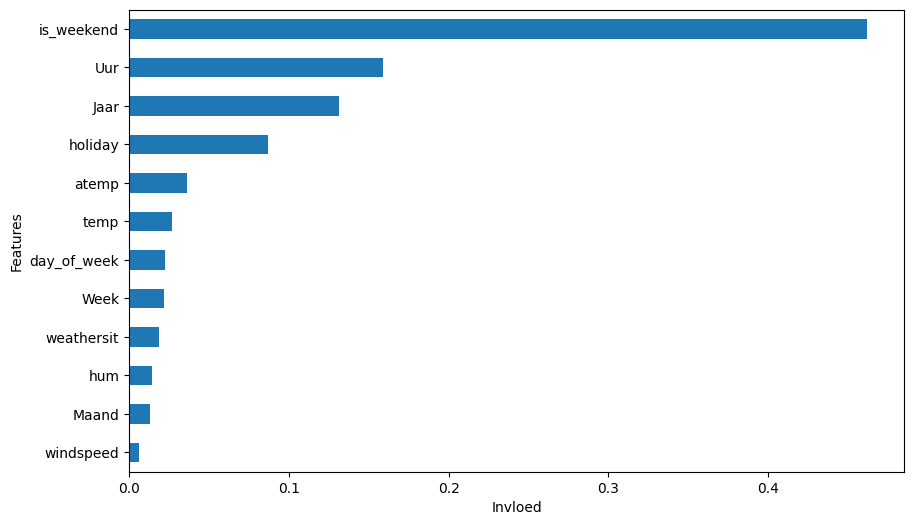

In [40]:
feature_scan(xgb_hm)

Nu de feature importances bekeken zijn en de RMSE is berekend kunnen de waarden omgezet worden tot een dataframe die ingeleverd kan worden op kaggle. Deze code is gebaseerd op de code uit de submissie functie, echter was het niet mogelijk om de functie te gebruiken. Dit is wegens de samenvoeging van de voorspellingen.

In [41]:
# Voorspellen op df_test
lr_test = lr_hm.predict(df_test)
xgb_test = xgb_hm.predict(df_test)

# Samenvoegen voorspelling
y_pred = np.round(lr_test + xgb_test).astype(int)

# Aanmaken df met alleen p_id en Outcome
test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': abs(y_pred)})

# Aanmaken van tijd
#tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

# Aanmaken csv bestand met timestamp
#test_predictions_df.to_csv(
#        f'Kaggle Submissions/vs_HML_try_{tijd}.csv',
#        index=False)

# print voor conformatie
#print(f'vs_HML_try_{tijd}.csv has been saved!')

## **H4: Bevindingen** <a name='h4'></a>

## **H5: Conclusie** <a name='h5'></a>

## **Literatuurlijst** <a name='bronnen'></a>

Voor alle onderwerpen is gebruik gemaakt van de Datacamps en de lesopgaven.

**Random Forest**:
- Chakure, A. (2022, March 7). Random forest regression in Python explained. Built In. https://builtin.com/data-science/random-forest-python

**XGBoost**:
- Kumar, N. (9 maart 2019). Advantages of XGBOOST Algorithm in Machine Learning. http://theprofessionalspoint.blogspot.com/2019/03/advantages-of-xgboost-algorithm-in.html
- Hachcham, A. (2023, August 11). XGBoost: Everything you need to know. neptune.ai. https://neptune.ai/blog/xgboost-everything-you-need-to-know

**Ensemble Model**:
- Brownlee, J. (2021, April 26). Stacking ensemble machine learning with Python. MachineLearningMastery.com. https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
- sklearn.ensemble.StackingRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

**Hybride Model**:
- Holbrook, R. (2023, April 20). Hybrid models. Kaggle. https://www.kaggle.com/code/ryanholbrook/hybrid-models